In [1]:
# Importing modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
# Reading in the data
GME = pd.read_csv('https://raw.githubusercontent.com/PrasoonPratham/Predicting-Followers/main/GME.csv')

In [3]:
GME.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-21,4.75,4.75,4.55,4.59,4.59,3532100
1,2020-01-22,4.55,4.64,4.46,4.56,4.56,2627500
2,2020-01-23,4.55,4.64,4.46,4.62,4.62,1880200
3,2020-01-24,4.64,4.64,4.25,4.32,4.32,4163600
4,2020-01-27,4.20,4.35,4.16,4.28,4.28,2122500


In [3]:
# Isolating the date and close price
GME = GME[['Date', 'Close']]

In [4]:
GME.head()

,Date,Close
0,2020-01-21,4.59
1,2020-01-22,4.56
2,2020-01-23,4.62
3,2020-01-24,4.32
4,2020-01-27,4.28


In [5]:
# Converting the date series to a datetime object
GME.Time = pd.to_datetime(GME.Date, format = '%Y/%m/%d')

In [6]:
# Setting the index 
plot_GME = GME.set_index('Date')

# Plot of the GME stock price dataset

<AxesSubplot:xlabel='Date'>

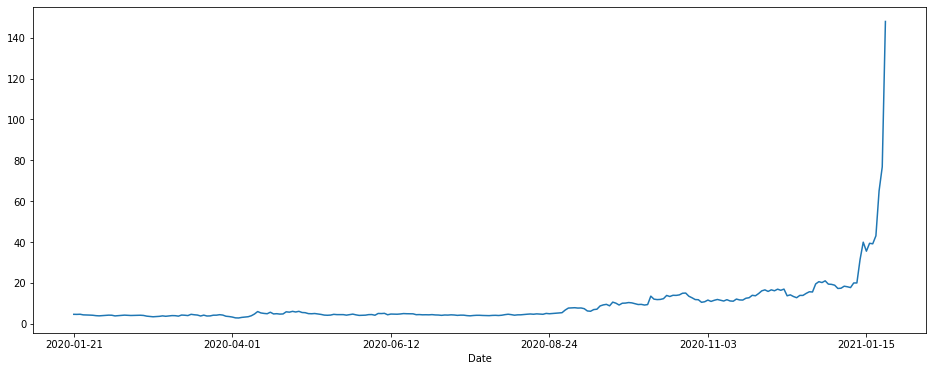

In [7]:
plot_GME['Close'].plot(figsize=(16,6))

# Selecting the portion of dataset we want to predict
Upon visual inspection, the time series is roughly stationary from the period of 2014 through the end of 2016, so let's reduce the dataset to 2014 through 2016. Stationarity means that the time series has a constant mean and variance over a certain time horizon. 

Start date: 1/1/14 -> index = 884

End date: 12/31/16 -> index = 1639

In [8]:
new_GME = GME

In [9]:
new_GME.head()

,Date,Close
0,2020-01-21,4.59
1,2020-01-22,4.56
2,2020-01-23,4.62
3,2020-01-24,4.32
4,2020-01-27,4.28


In [10]:
new_GME.tail()

,Date,Close
252,2021-01-20,39.119999
253,2021-01-21,43.029999
254,2021-01-22,65.010002
255,2021-01-25,76.790001
256,2021-01-26,147.979996


In [11]:
new_GME.dropna()

,Date,Close
0,2020-01-21,4.590000
1,2020-01-22,4.560000
2,2020-01-23,4.620000
3,2020-01-24,4.320000
4,2020-01-27,4.280000
...,...,...
252,2021-01-20,39.119999
253,2021-01-21,43.029999
254,2021-01-22,65.010002
255,2021-01-25,76.790001


# Feature Preprocessing
Below, we apply a min-max scaler to the dataset, and then convert it to a supervised learning problem. Basically, you can visualize the conversion in terms of a "sliding window", that divides the dataset into many different windows of length 20 days, that allow us to predict the 21st day. As the window slides from left to right, we are able to use a LSTM model to predict a "future" day from 20 preceding days.

## Min-max Scaling and Train/Test Split

In [12]:
new_GME = new_GME.drop('Date', axis = 1)
new_GME = new_GME.reset_index(drop = True)
new_GME.head()
print(new_GME.isnull().sum())
new_GME.dropna()
T = new_GME.values
T = T.astype('float32')
T = np.reshape(T, (-1, 1))

Close    0
dtype: int64


In [13]:
T = T[~np.isnan(T)]
T = np.reshape(T, (-1, 1))

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
T = scaler.fit_transform(T)

# 80-20 split
train_size = int(len(T) * 0.80)
test_size = int(len(T) - train_size)
train, test = T[0:train_size,:], T[train_size:len(T),:]

In [15]:
# Method for create features from the time series data
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

# Roughly one month of trading assuming 5 trading days per week
window_size = 20
X_train, Y_train = create_features(train, window_size)

X_test, Y_test = create_features(test, window_size)

# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [16]:
# Checking to make sure that none of our training set is leaking into the testing set
T_shape = T.shape
train_shape = train.shape
test_shape = test.shape

# Make sure that the number of rows in the dataset = train rows + test rows
def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(T_shape, train_shape, test_shape))

False


In [17]:
# Model imports
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

In [18]:
# Setting seed for reproducibility 
tf.random.set_seed(11)
np.random.seed(11)

# Building the  LSTM RNN Model
Below, we build a LSTM model that consists of one LSTM layer with a density of 50 neurons and a RELU activation function, as well as a Dropout regularization layer. We add a model checkpoint that is looking to minimize the validation set's loss. We save each model that consists of a lower validation loss compared to any model that came before it.

In [19]:
# Building model
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', #return_sequences = True, 
               input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [2]:
import os
os.system("mkdir GME")

#Create dir

0

In [ ]:
filepath = './GME/model_epoch_{epoch:02d}.hdf5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode ='min'
                            )

history = model.fit(X_train, Y_train, epochs = 500, batch_size = 80, validation_data = (X_test, Y_test), 
                    callbacks = [checkpoint], 
                    verbose = 1, shuffle = False)

model.summary()

## Why we chose the model at epoch 89
The model at epoch 89 had the most similar training and validation losses, which implies that the model is not doing a lot of over or under fitting. As such, we load that model. 

In [29]:
from keras.models import load_model

best_model = load_model('./GME/model_epoch_558.hdf5')

# Predicting and inverse transforming the predictions

train_predict = best_model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = best_model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)



In [22]:
# Inverse transforming the actual values, to return them to their original values
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [30]:
Y_hat_train = np.reshape(Y_hat_train, newshape = 184)
Y_hat_test = np.reshape(Y_hat_test, newshape = 31)

Y_train = np.reshape(Y_train, newshape = 184)
Y_test = np.reshape(Y_test, newshape = 31)

# Evaluating Model Performance
## Computing the RMSE for the training and testing sets

In [31]:
from sklearn.metrics import mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
0.7116989301979225 

Test RMSE is: 
8.4882838119775


## Visualizing the actual vs. predicted stock prices

In [32]:
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

In [33]:
result_df = pd.DataFrame()

result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat


result_df.head()

,Actual_Y,Predicted_Y
0,4.15,4.387855
1,4.14,4.390002
2,4.04,4.402129
3,3.70,4.400368
4,3.56,4.341805


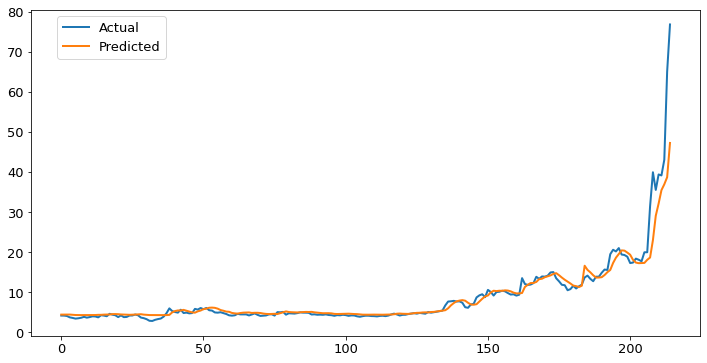

In [34]:
plt.figure(figsize = (12,6))
plt.plot(result_df["Actual_Y"],linewidth=2.0,label = "Actual")
plt.plot(result_df["Predicted_Y"],linewidth=2.0, label = "Predicted")
plt.rcParams.update({'font.size': 13})
plt.legend(loc="upper left", bbox_to_anchor=(0.03,1))
plt.show()